In [10]:
#Acelerómetro vs. Giroscopio
#Importación de Librerías

import pandas as pd
import numpy as np
import os
import glob
import time
from multiprocessing import Pool, cpu_count

# Funciones de SciPy y Scikit-learn
from scipy.fft import fft, fftfreq
from scipy.stats import entropy, mode
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Visualización
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# --- Funciones de Carga y Extracción de Características ---

def cargar_datos_completos(archivo_sensor, nombre_sensor):
    """Carga y pre-limpia los datos para un sensor específico."""
    lista_datos = []
    if os.path.exists(archivo_sensor):
        print(f"Cargando y procesando archivo: {archivo_sensor}...")
        datos_temporales = pd.read_csv(archivo_sensor, on_bad_lines='skip')
        datos_temporales.dropna(subset=['gt', 'x', 'y', 'z'], inplace=True)
        datos_temporales = datos_temporales[datos_temporales['gt'] != 'null']
        datos_temporales['sensor'] = nombre_sensor
        lista_datos.append(datos_temporales)
    else:
        print(f"Advertencia: No se encontró el archivo '{archivo_sensor}'. Se omitirá.")
        return pd.DataFrame()
        
    if not lista_datos:
        return pd.DataFrame()
    return pd.concat(lista_datos, ignore_index=True)

def calcular_sma(ventana):
    return np.mean(np.abs(ventana['x']) + np.abs(ventana['y']) + np.abs(ventana['z']))

def calcular_entropia_espectral(ventana):
    valor_entropia = 0
    for eje in ['x', 'y', 'z']:
        valores_fft = np.abs(fft(ventana[eje].values))
        potencia_fft = valores_fft**2
        if np.sum(potencia_fft) > 0:
            distribucion_potencia = potencia_fft / np.sum(potencia_fft)
            valor_entropia += entropy(distribucion_potencia)
    return valor_entropia / 3

def extraer_caracteristicas(ventana):
    caracteristicas = {}
    for eje in ['x', 'y', 'z']:
        caracteristicas[f'mean_{eje}'] = ventana[eje].mean()
        caracteristicas[f'std_{eje}'] = ventana[eje].std()
    caracteristicas['corr_xy'] = ventana['x'].corr(ventana['y'])
    caracteristicas['corr_yz'] = ventana['y'].corr(ventana['z'])
    caracteristicas['corr_zx'] = ventana['z'].corr(ventana['x'])
    caracteristicas['sma'] = calcular_sma(ventana)
    caracteristicas['spectral_entropy'] = calcular_entropia_espectral(ventana)
    for eje in ['x', 'y', 'z']:
        caracteristicas[f'jerk_mean_{eje}'] = np.mean(np.diff(ventana[eje], n=1))
    valores_fft = np.abs(fft(ventana['x'].values + ventana['y'].values + ventana['z'].values))
    frecuencias_fft = fftfreq(len(ventana), 1/100)
    indice_frec_dominante = np.argmax(valores_fft[1:]) + 1
    caracteristicas['dominant_freq'] = frecuencias_fft[indice_frec_dominante]
    for eje in ['x', 'y', 'z']:
        caracteristicas[f'energy_{eje}'] = np.mean(ventana[eje]**2)
    return pd.Series(caracteristicas).fillna(0)

def crear_ventanas_y_extraer_caracteristicas(clave_datos, datos_dispositivo_sensor):
    TAMANO_VENTANA = 128
    PASO = 64
    if len(datos_dispositivo_sensor) < TAMANO_VENTANA:
        return pd.DataFrame(), np.array([]) 
    
    lista_caracteristicas, lista_etiquetas = [], []
    for inicio in range(0, len(datos_dispositivo_sensor) - TAMANO_VENTANA, PASO):
        fin = inicio + TAMANO_VENTANA
        ventana = datos_dispositivo_sensor.iloc[inicio:fin]
        caracteristicas = extraer_caracteristicas(ventana)
        caracteristicas['Device'] = clave_datos[0]
        lista_caracteristicas.append(caracteristicas)
        lista_etiquetas.append(mode(ventana['activity_code'], keepdims=True).mode[0])
        
    return pd.DataFrame(lista_caracteristicas), np.array(lista_etiquetas)

def procesar_grupo(grupo):
    """Función 'worker' para la extracción de características."""
    clave, datos = grupo
    df_caracteristicas, array_etiquetas = crear_ventanas_y_extraer_caracteristicas(clave, datos)
    
    if not df_caracteristicas.empty:
        df_caracteristicas['label'] = array_etiquetas
    return df_caracteristicas

print("Funciones de carga y extracción definidas")

Funciones de carga y extracción definidas


In [ ]:
# --- Función de Entrenamiento ---

def entrenar_modelo_por_dispositivo(tupla_grupo):
    """
    Función 'worker' para el entrenamiento.
    Toma una tupla (nombre_dispositivo, datos_grupo) y retorna
    (nombre_dispositivo, {'svm': modelo, 'escalador': escalador}).
    """
    nombre_dispositivo, grupo = tupla_grupo
    
    try:
        y_grupo = grupo['label']
        X_grupo = grupo.drop(['label', 'Device'], axis=1)
        
        if X_grupo.empty or y_grupo.empty:
            return (nombre_dispositivo, None)

        escalador = StandardScaler()
        X_grupo_escalado = escalador.fit_transform(X_grupo)
        
        svm = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)
        svm.fit(X_grupo_escalado, y_grupo)
        
        return (nombre_dispositivo, {'svm': svm, 'escalador': escalador})
    
    except Exception as e:
        print(f"Error entrenando {nombre_dispositivo}: {e}")
        return (nombre_dispositivo, None)

print("Función de entrenamiento definida.")

Función de entrenamiento definida.


In [4]:
# --- Configuración de los Experimentos ---

# Lista de sensores a probar
#SENSORES_A_PROBAR = {
#    'Accelerometer': 'Phones_accelerometer.csv',
#    'Gyroscope': 'Phones_gyroscope.csv'
#}

SENSORES_A_PROBAR = {
    'Phones Accelerometer': '/home/angel/Documentos/CÓMPUTO PARALELO/PROYECTO/Phones_accelerometer.csv',
    'Phones Gyroscope': '/home/angel/Documentos/CÓMPUTO PARALELO/PROYECTO/Phones_gyroscope.csv',
    'Watch Accelerometer': '/home/angel/Documentos/CÓMPUTO PARALELO/PROYECTO/Watch_accelerometer.csv',
    'Watch Gyroscope': '/home/angel/Documentos/CÓMPUTO PARALELO/PROYECTO/Watch_gyroscope.csv'
}



# Lista de núcleos a probar.
MAXIMOS_NUCLEOS = cpu_count()
CONTEO_NUCLEOS_A_PROBAR = [2, 4, 8, 12, 16, 20]
# Nos aseguramos de no probar más núcleos de los que tienes
CONTEO_NUCLEOS_A_PROBAR = [n for n in CONTEO_NUCLEOS_A_PROBAR if n <= MAXIMOS_NUCLEOS]

print(f"Se probarán {len(SENSORES_A_PROBAR)} sensores.")
print(f"Máximo de núcleos detectados: {MAXIMOS_NUCLEOS}")
print(f"Se probará N=1 (Secuencial) y N={CONTEO_NUCLEOS_A_PROBAR} (Paralelo)")

# Diccionarios para guardar todos nuestros resultados
todos_los_resultados = {}
datos_evaluacion_modelos = {}

Se probarán 4 sensores.
Máximo de núcleos detectados: 20
Se probará N=1 (Secuencial) y N=[2, 4, 8, 12, 16, 20] (Paralelo)


In [5]:
# --- Bucle Principal de Análisis ---
# Esto ejecutará todo el proceso para cada sensor.

for nombre_sensor, archivo_sensor in SENSORES_A_PROBAR.items():
    print(f"\n" + "="*80)
    print(f"Iniciando Análisis para: {nombre_sensor} ({archivo_sensor})")
    print("="*80)
    
    # --- 1. Carga y Preparación de Datos (para este sensor) ---
    datos = cargar_datos_completos(archivo_sensor, nombre_sensor)
    if datos.empty:
        print(f"No se pudieron cargar datos para {nombre_sensor}. Saltando...")
        continue

    # LabelEncoder específico para este dataset
    codificador_etiquetas = LabelEncoder()
    datos['activity_code'] = codificador_etiquetas.fit_transform(datos['gt'])
    datos[['x', 'y', 'z']] = datos[['x', 'y', 'z']].astype(np.float64)
    
    # Preparar los datos para map/pool.map
    datos_agrupados = list(datos.groupby(['Device', 'sensor']))
    
    print(f"Datos cargados para {nombre_sensor}. {len(datos_agrupados)} grupos de dispositivos.")

    # --- 2. Experimento SECUENCIAL (N=1) ---
    print("\n--- (N=1) Iniciando Experimento SECUENCIAL (Baseline) ---")
    
    # 2.1 Extracción de Features Secuencial
    print("  (N=1) Extrayendo características...")
    inicio_feat_sec = time.time()
    lista_df_resultados_sec = list(map(procesar_grupo, datos_agrupados))
    fin_feat_sec = time.time()
    Ts_caracteristicas = fin_feat_sec - inicio_feat_sec
    print(f"  (N=1) Extracción de features: {Ts_caracteristicas:.4f} s")

    # 2.2 Preparación de Entrenamiento
    df_todas_caracteristicas_sec = pd.concat(lista_df_resultados_sec, ignore_index=True)
    y_sec = df_todas_caracteristicas_sec['label']
    X_sec = df_todas_caracteristicas_sec.drop('label', axis=1)
    X_entrenamiento_sec, X_prueba_sec, y_entrenamiento_sec, y_prueba_sec = train_test_split(
        X_sec, y_sec, test_size=0.2, random_state=42, stratify=y_sec
    )
    datos_entrenamiento_sec = pd.concat([X_entrenamiento_sec, y_entrenamiento_sec], axis=1)
    datos_entrenamiento_agrupados_sec = list(datos_entrenamiento_sec.groupby('Device'))

    # 2.3 Entrenamiento Secuencial
    print("  (N=1) Entrenando modelos...")
    inicio_entren_sec = time.time()
    resultados_sec = list(map(entrenar_modelo_por_dispositivo, datos_entrenamiento_agrupados_sec))
    fin_entren_sec = time.time()
    Ts_entrenamiento = fin_entren_sec - inicio_entren_sec
    print(f"  (N=1) Entrenamiento: {Ts_entrenamiento:.4f} s")

    # 2.4 Resultados Secuenciales (Baseline)
    Ts_total = Ts_caracteristicas + Ts_entrenamiento
    todos_los_resultados[nombre_sensor] = [{
        'N': 1,
        'Tiempo (s)': Ts_total,
        'Aceleracion': 1.0,
        'Eficiencia': 1.0,
        'T_Features (s)': Ts_caracteristicas,
        'T_Training (s)': Ts_entrenamiento
    }]
    print(f"--- (N=1) TIEMPO TOTAL SECUENCIAL: {Ts_total:.4f} s ---")

    # 2.5 Guardar modelo para evaluación
    datos_evaluacion_modelos[nombre_sensor] = (
        dict(resultados_sec), 
        X_prueba_sec.drop('Device', axis=1), 
        y_prueba_sec, 
        codificador_etiquetas.classes_
    )
    
    # --- 3. Experimentos PARALELOS (N > 1) ---
    for N in CONTEO_NUCLEOS_A_PROBAR:
        print(f"\n--- (N={N}) Iniciando Experimento PARALELO ---")
        
        # 3.1 Extracción de Features Paralela
        print(f"  (N={N}) Extrayendo características...")
        inicio_feat_par = time.time()
        with Pool(N) as pool:
            lista_df_resultados_par = pool.map(procesar_grupo, datos_agrupados)
        fin_feat_par = time.time()
        Tp_caracteristicas = fin_feat_par - inicio_feat_par
        print(f"  (N={N}) Extracción de features: {Tp_caracteristicas:.4f} s")

        # 3.2 Entrenamiento Paralelo
        print(f"  (N={N}) Entrenando modelos...")
        inicio_entren_par = time.time()
        with Pool(N) as pool:
            resultados_par = pool.map(entrenar_modelo_por_dispositivo, datos_entrenamiento_agrupados_sec)
        fin_entren_par = time.time()
        Tp_entrenamiento = fin_entren_par - inicio_entren_par
        print(f"  (N={N}) Entrenamiento: {Tp_entrenamiento:.4f} s")
        
        # 3.3 Resultados Paralelos
        Tp_total = Tp_caracteristicas + Tp_entrenamiento
        aceleracion = Ts_total / Tp_total
        eficiencia = aceleracion / N
        
        todos_los_resultados[nombre_sensor].append({
            'N': N,
            'Tiempo (s)': Tp_total,
            'Aceleracion': aceleracion,
            'Eficiencia': eficiencia,
            'T_Features (s)': Tp_caracteristicas,
            'T_Training (s)': Tp_entrenamiento
        })
        print(f"--- (N={N}) TIEMPO TOTAL PARALELO: {Tp_total:.4f} s ---")
        print(f"--- (N={N}) Aceleración: {aceleracion:.2f}x, Eficiencia: {eficiencia:.2%} ---")

    print(f"\n" + "="*80)
    print(f"Análisis para {nombre_sensor} completado.")
    print("="*80)

print("\n\nTODOS LOS EXPERIMENTOS HAN FINALIZADO.")


Iniciando Análisis para: Phones Accelerometer (/home/angel/Documentos/CÓMPUTO PARALELO/PROYECTO/Phones_accelerometer.csv)
Cargando y procesando archivo: /home/angel/Documentos/CÓMPUTO PARALELO/PROYECTO/Phones_accelerometer.csv...
Datos cargados para Phones Accelerometer. 8 grupos de dispositivos.

--- (N=1) Iniciando Experimento SECUENCIAL (Baseline) ---
  (N=1) Extrayendo características...
  (N=1) Extracción de features: 256.9357 s
  (N=1) Entrenando modelos...
  (N=1) Entrenamiento: 15.0493 s
--- (N=1) TIEMPO TOTAL SECUENCIAL: 271.9850 s ---

--- (N=2) Iniciando Experimento PARALELO ---
  (N=2) Extrayendo características...
  (N=2) Extracción de features: 142.0289 s
  (N=2) Entrenando modelos...
  (N=2) Entrenamiento: 8.0755 s
--- (N=2) TIEMPO TOTAL PARALELO: 150.1045 s ---
--- (N=2) Aceleración: 1.81x, Eficiencia: 90.60% ---

--- (N=4) Iniciando Experimento PARALELO ---
  (N=4) Extrayendo características...
  (N=4) Extracción de features: 86.7882 s
  (N=4) Entrenando modelos...
  


################################################################################
Resultados de Rendimiento para: Phones Accelerometer
################################################################################
Módulo 'tabulate' no encontrado. Imprimiendo DataFrame estándar.
    Tiempo (s)  Aceleracion  Eficiencia  T_Features (s)  T_Training (s)
N                                                                      
1   271.985032     1.000000    1.000000      256.935701       15.049332
2   150.104461     1.811972    0.905986      142.028933        8.075527
4    92.848573     2.929340    0.732335       86.788220        6.060354
8    84.996510     3.199955    0.399994       78.549023        6.447487
12   84.729372     3.210044    0.267504       78.547656        6.181716
16   87.343275     3.113978    0.194624       80.315471        7.027804
20   85.014383     3.199283    0.159964       78.492037        6.522346


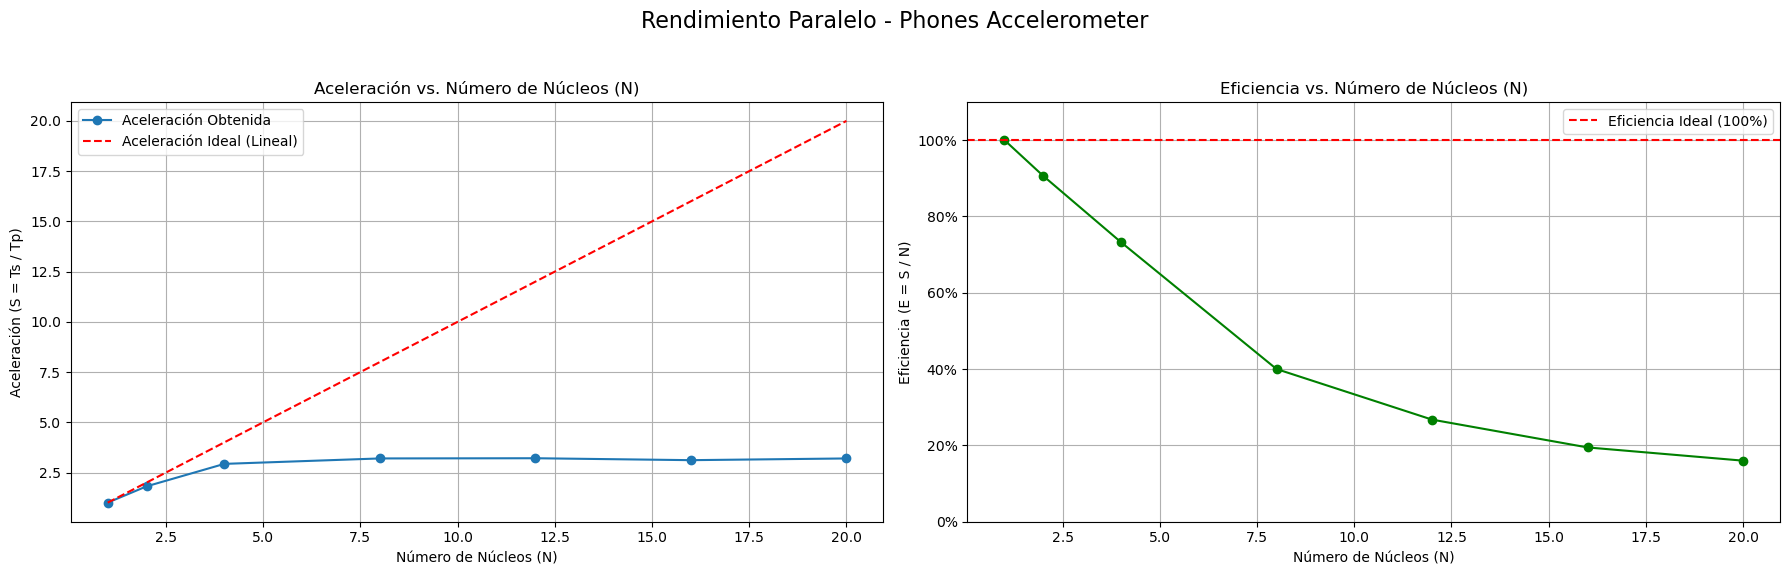


################################################################################
Resultados de Rendimiento para: Phones Gyroscope
################################################################################
Módulo 'tabulate' no encontrado. Imprimiendo DataFrame estándar.
    Tiempo (s)  Aceleracion  Eficiencia  T_Features (s)  T_Training (s)
N                                                                      
1   309.217777     1.000000    1.000000      276.095144       33.122633
2   170.365641     1.815024    0.907512      153.085509       17.280132
4   110.040697     2.810031    0.702508       97.740449       12.300248
8    90.350961     3.422407    0.427801       77.866303       12.484659
12   89.794612     3.443612    0.286968       77.403065       12.391547
16   89.188844     3.467001    0.216688       76.951518       12.237326
20   90.435799     3.419197    0.170960       77.883140       12.552659


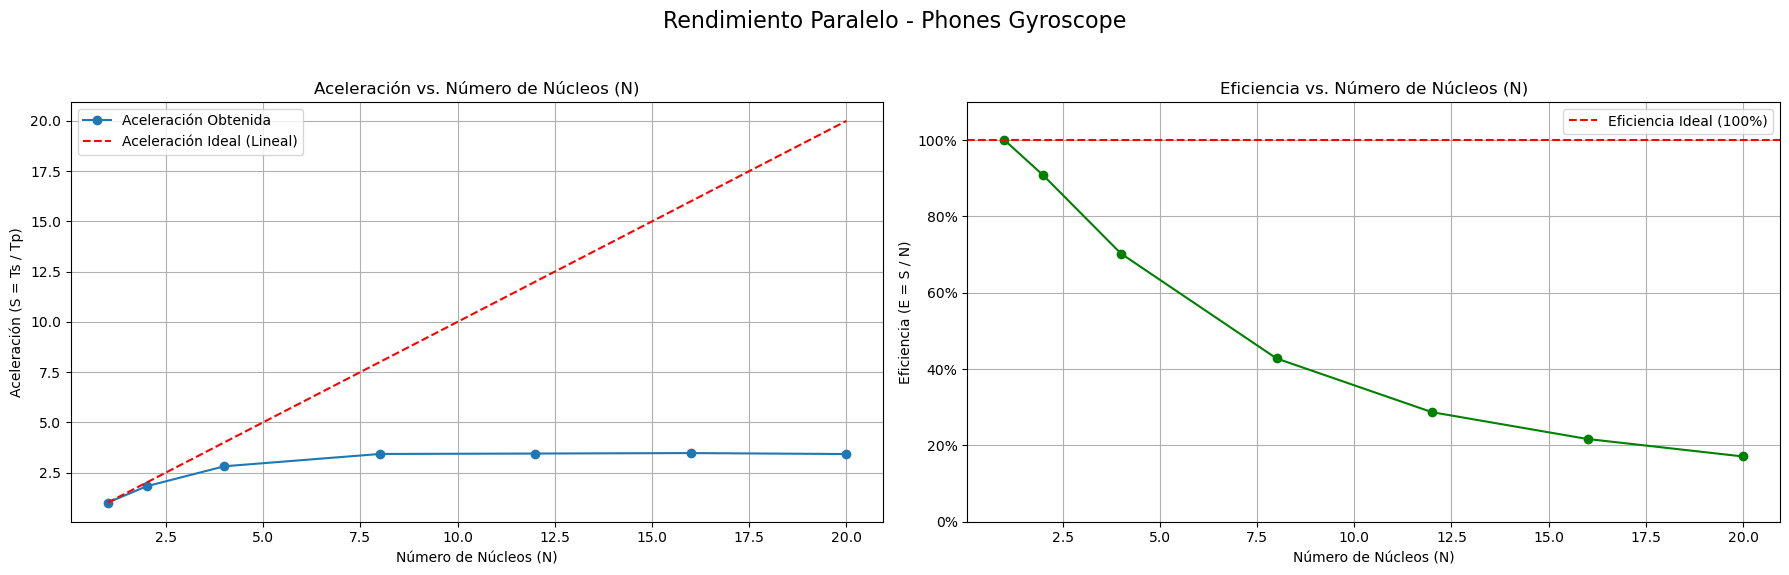


################################################################################
Resultados de Rendimiento para: Watch Accelerometer
################################################################################
Módulo 'tabulate' no encontrado. Imprimiendo DataFrame estándar.
    Tiempo (s)  Aceleracion  Eficiencia  T_Features (s)  T_Training (s)
N                                                                      
1    74.799791     1.000000    1.000000       68.826253        5.973538
2    58.287332     1.283294    0.641647       53.289885        4.997447
4    58.140880     1.286527    0.321632       53.102227        5.038654
8    57.673868     1.296944    0.162118       52.558650        5.115218
12   58.087378     1.287712    0.107309       52.936822        5.150556
16   58.316525     1.282652    0.080166       52.925379        5.391146
20   58.484704     1.278963    0.063948       53.060007        5.424697


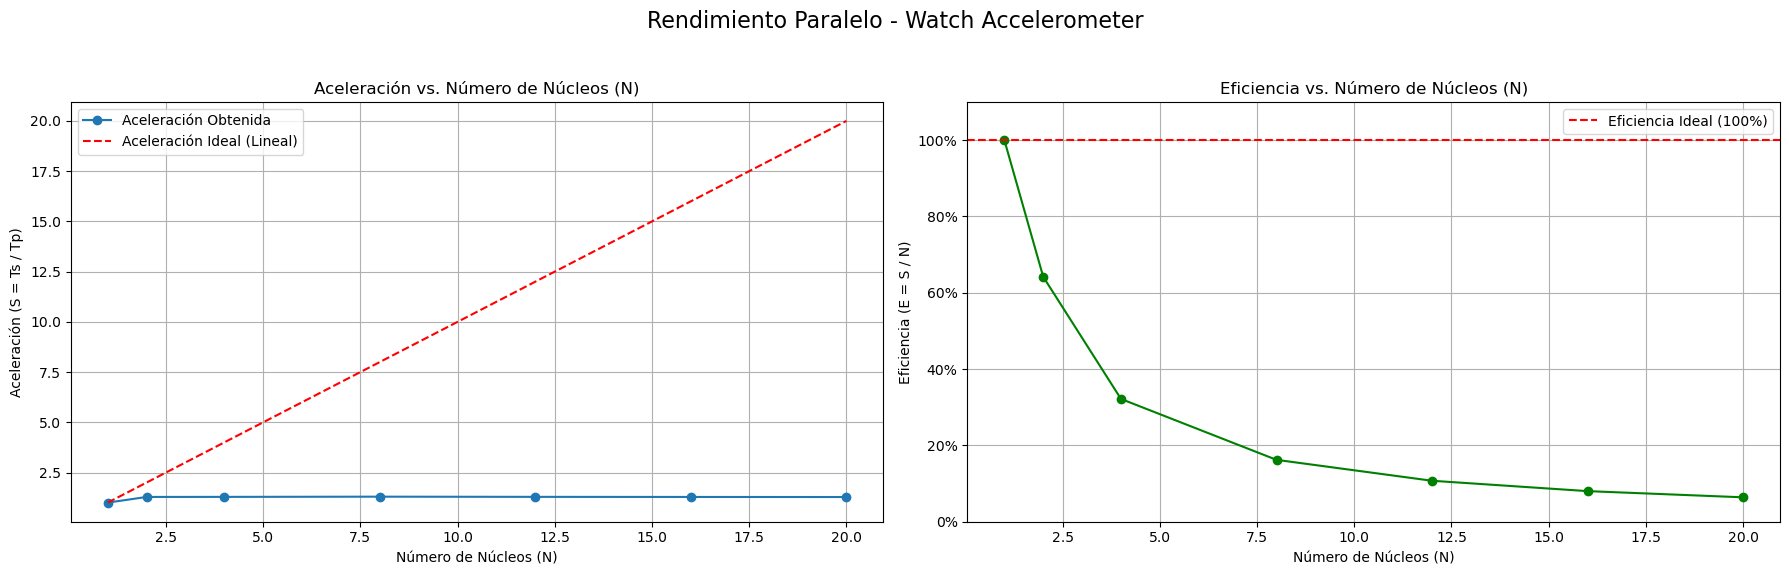


################################################################################
Resultados de Rendimiento para: Watch Gyroscope
################################################################################
Módulo 'tabulate' no encontrado. Imprimiendo DataFrame estándar.
    Tiempo (s)  Aceleracion  Eficiencia  T_Features (s)  T_Training (s)
N                                                                      
1    71.056741     1.000000    1.000000       62.276400        8.780341
2    60.696137     1.170696    0.585348       52.025679        8.670458
4    60.129871     1.181721    0.295430       51.420309        8.709562
8    60.185554     1.180628    0.147578       51.381051        8.804502
12   60.570920     1.173116    0.097760       51.615038        8.955882
16   60.286618     1.178649    0.073666       51.348737        8.937880
20   60.577617     1.172987    0.058649       51.471664        9.105953


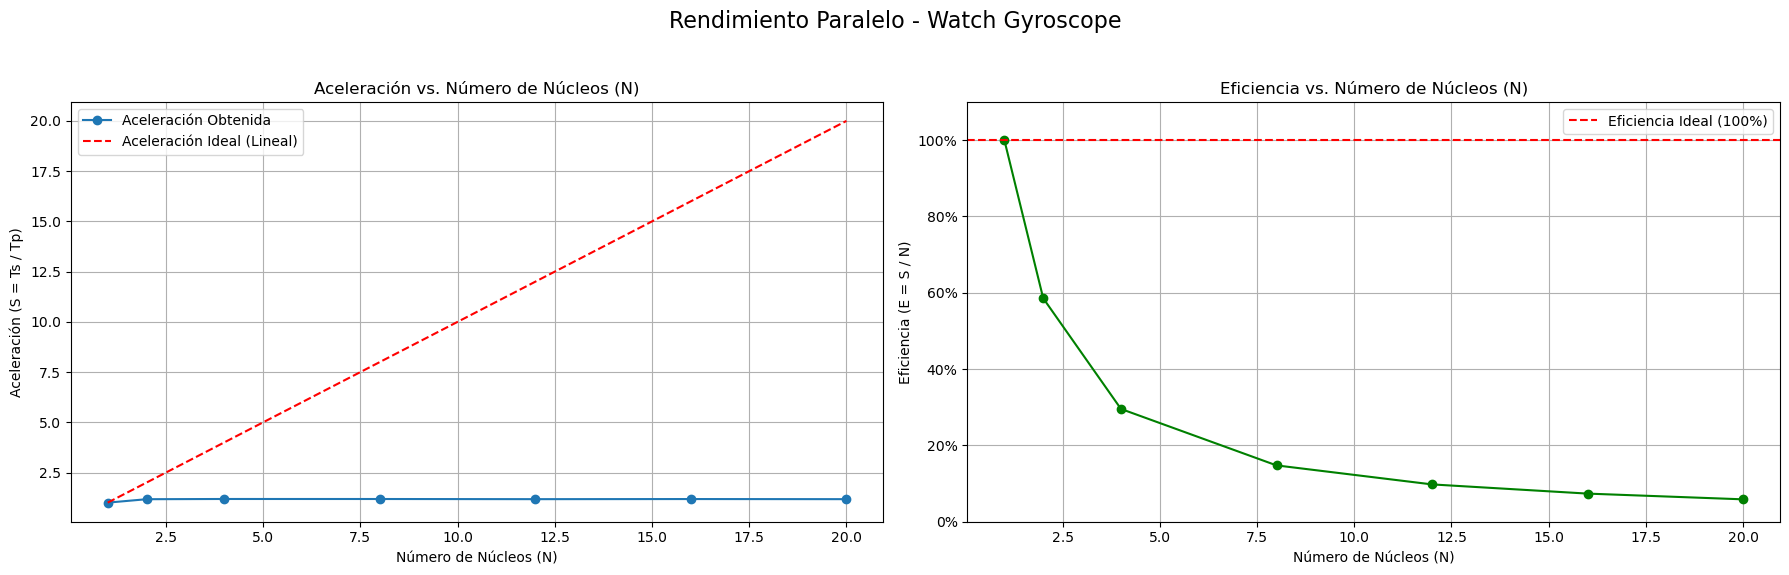

In [6]:
# --- Visualización de Métricas de Rendimiento ---

for nombre_sensor, resultados in todos_los_resultados.items():
    print(f"\n" + "#"*80)
    print(f"Resultados de Rendimiento para: {nombre_sensor}")
    print("#"*80)
    
    # 1. Mostrar Tabla de Resultados
    df_resultados = pd.DataFrame(resultados).set_index('N')
    # Usamos .to_markdown() que causó el error anterior
    try:
        print(df_resultados.to_markdown(floatfmt=".4f"))
    except ImportError:
        print("Módulo 'tabulate' no encontrado. Imprimiendo DataFrame estándar.")
        print(df_resultados)
    
    # 2. Crear Gráficas
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    fig.suptitle(f'Rendimiento Paralelo - {nombre_sensor}', fontsize=16)
    
    # Gráfica de Aceleración (Speedup)
    ax1.plot(df_resultados.index, df_resultados['Aceleracion'], 'o-', label='Aceleración Obtenida')
    ax1.plot(df_resultados.index, df_resultados.index, 'r--', label='Aceleración Ideal (Lineal)')
    ax1.set_title('Aceleración vs. Número de Núcleos (N)')
    ax1.set_xlabel('Número de Núcleos (N)')
    ax1.set_ylabel('Aceleración (S = Ts / Tp)')
    ax1.legend()
    ax1.grid(True)
    
    # Gráfica de Eficiencia
    ax2.plot(df_resultados.index, df_resultados['Eficiencia'], 'o-g')
    ax2.axhline(y=1.0, color='r', linestyle='--', label='Eficiencia Ideal (100%)')
    ax2.set_title('Eficiencia vs. Número de Núcleos (N)')
    ax2.set_xlabel('Número de Núcleos (N)')
    ax2.set_ylabel('Eficiencia (E = S / N)')
    ax2.set_ylim(0, 1.1)
    ax2.yaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


################################################################################
Evaluación de la Calidad de los Modelos
################################################################################

--- Reporte de Clasificación para: Phones Accelerometer ---

Precisión (Accuracy) del modelo: 82.91%

Reporte de Clasificación:
              precision    recall  f1-score   support

        bike       0.87      0.96      0.91      5765
         sit       0.91      0.93      0.92      6226
  stairsdown       0.68      0.79      0.73      5055
    stairsup       0.71      0.74      0.73      5564
       stand       0.92      0.94      0.93      5785
        walk       0.89      0.63      0.74      6851

    accuracy                           0.83     35246
   macro avg       0.83      0.83      0.83     35246
weighted avg       0.84      0.83      0.83     35246



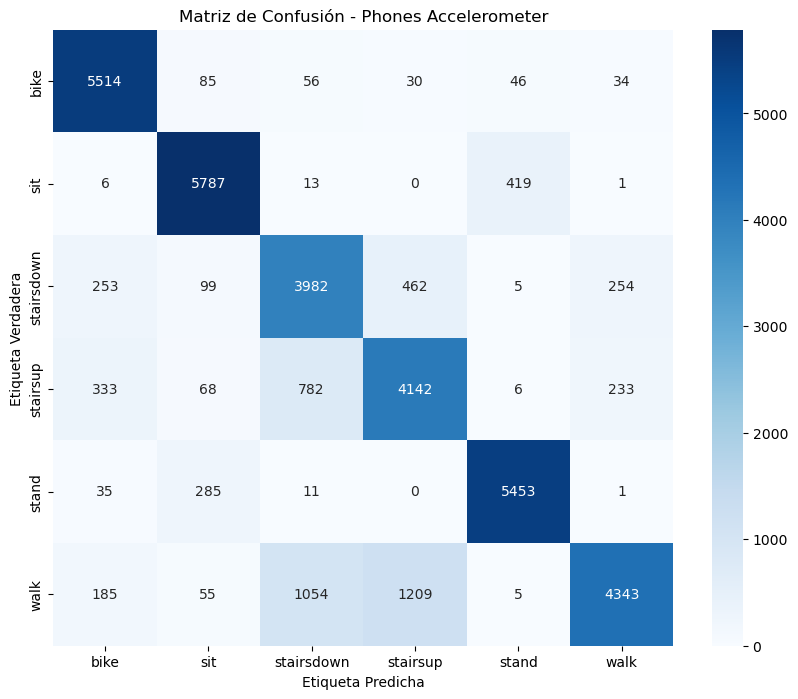


--- Reporte de Clasificación para: Phones Gyroscope ---

Precisión (Accuracy) del modelo: 82.56%

Reporte de Clasificación:
              precision    recall  f1-score   support

        bike       0.89      0.89      0.89      5973
         sit       0.75      0.80      0.77      6934
  stairsdown       0.78      0.85      0.81      5233
    stairsup       0.88      0.87      0.87      5886
       stand       0.75      0.70      0.73      6324
        walk       0.90      0.86      0.88      7345

    accuracy                           0.83     37695
   macro avg       0.83      0.83      0.83     37695
weighted avg       0.83      0.83      0.83     37695



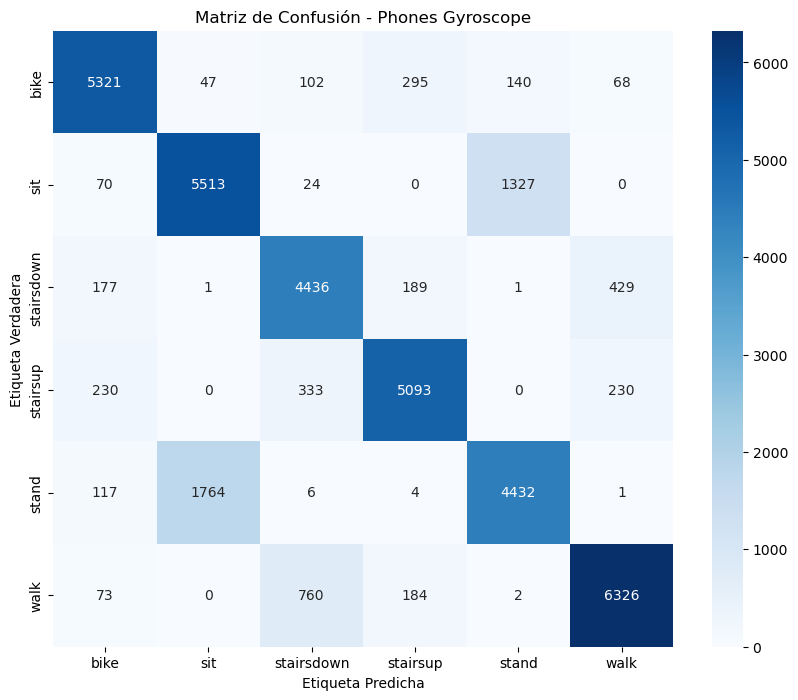


--- Reporte de Clasificación para: Watch Accelerometer ---

Precisión (Accuracy) del modelo: 72.69%

Reporte de Clasificación:
              precision    recall  f1-score   support

        bike       0.79      0.89      0.84      1986
         sit       0.88      0.81      0.84      1325
  stairsdown       0.57      0.55      0.56      1520
    stairsup       0.57      0.55      0.56      1480
       stand       0.83      0.88      0.86      1410
        walk       0.72      0.66      0.69      1718

    accuracy                           0.73      9439
   macro avg       0.72      0.72      0.72      9439
weighted avg       0.72      0.73      0.72      9439



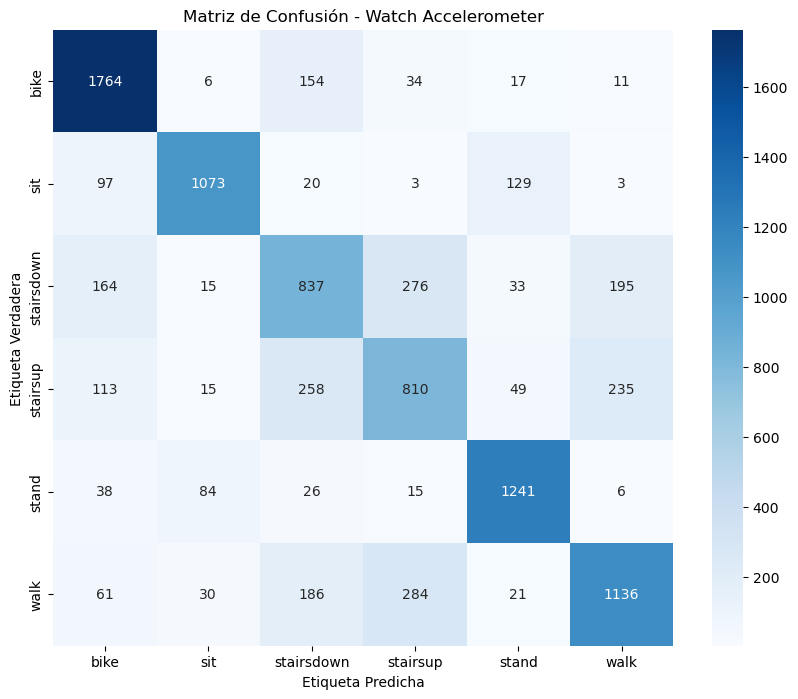


--- Reporte de Clasificación para: Watch Gyroscope ---

Precisión (Accuracy) del modelo: 60.16%

Reporte de Clasificación:
              precision    recall  f1-score   support

        bike       0.65      0.85      0.73      1634
         sit       0.66      0.46      0.54      1311
  stairsdown       0.58      0.54      0.56      1338
    stairsup       0.51      0.51      0.51      1393
       stand       0.58      0.76      0.66      1344
        walk       0.63      0.46      0.53      1526

    accuracy                           0.60      8546
   macro avg       0.60      0.60      0.59      8546
weighted avg       0.60      0.60      0.59      8546



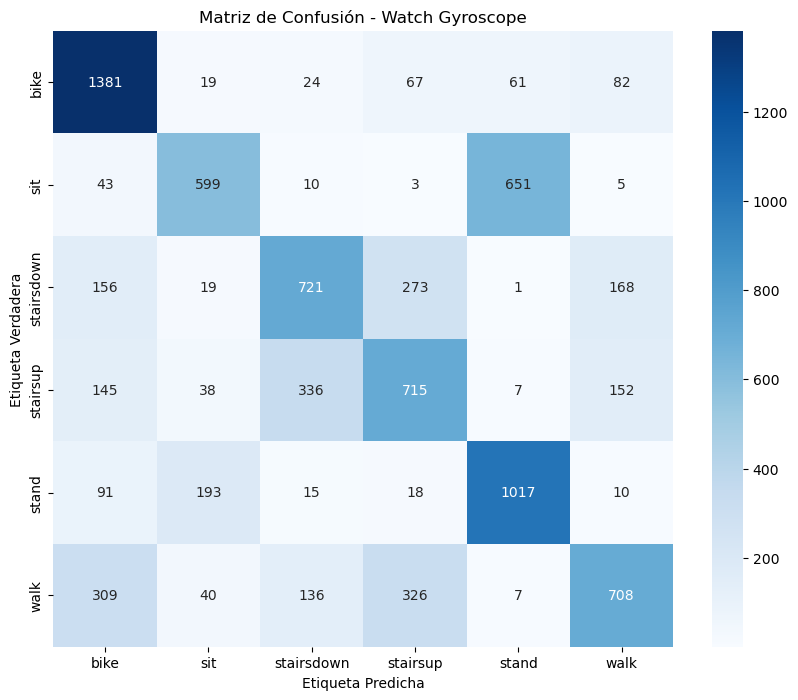

In [7]:
# --- Evaluación de Modelos (Usando los modelos del N=1) ---

print("\n" + "#"*80)
print("Evaluación de la Calidad de los Modelos")
print("#"*80)

for nombre_sensor, (modelos, X_prueba, y_prueba, clases) in datos_evaluacion_modelos.items():
    print(f"\n--- Reporte de Clasificación para: {nombre_sensor} ---")
    
    # Realizar predicciones
    todas_las_predicciones = []
    for nombre_dispositivo, datos_modelo in modelos.items():
        if datos_modelo is None:
            continue
            
        svm = datos_modelo['svm']
        escalador = datos_modelo['escalador']
        
        X_prueba_escalado = escalador.transform(X_prueba)
        predicciones = svm.predict(X_prueba_escalado)
        todas_las_predicciones.append(predicciones)
    
    # Votación mayoritaria
    if not todas_las_predicciones:
        print(f"No se generaron predicciones para {nombre_sensor}.")
        continue
        
    matriz_predicciones = np.array(todas_las_predicciones).T
    y_prediccion_votada, _ = mode(matriz_predicciones, axis=1, keepdims=False)

    # Mostrar Métricas de Clasificación
    precision = accuracy_score(y_prueba, y_prediccion_votada)
    reporte = classification_report(y_prueba, y_prediccion_votada, target_names=clases)
    
    print(f"\nPrecisión (Accuracy) del modelo: {precision * 100:.2f}%")
    print("\nReporte de Clasificación:")
    print(reporte)

    # Mostrar Matriz de Confusión
    matriz_confusion = confusion_matrix(y_prueba, y_prediccion_votada)
    plt.figure(figsize=(10, 8))
    sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', 
                xticklabels=clases, yticklabels=clases)
    plt.title(f'Matriz de Confusión - {nombre_sensor}')
    plt.ylabel('Etiqueta Verdadera')
    plt.xlabel('Etiqueta Predicha')
    plt.show()